              日期  质量等级  AQI指数  当天AQI排名  PM25  PM10  So2  No2    Co  O3
0     2019-01-01  重度污染    206      362   156   230   13   67  2.63  18
1     2019-01-02  重度污染    211      352   162   243    8   65  2.67  19
2     2019-01-03  重度污染    211      331   164   244    9   69  2.78  17
3     2019-01-04  重度污染    230      331   180   228   13   60  2.53  19
4     2019-01-05  中度污染    178      321   137   173   11   69  2.17  21
...          ...   ...    ...      ...   ...   ...  ...  ...   ...  ..
1059  2021-12-27  重度污染    201      332    57   330    5   46  1.14  26
1060  2021-12-28  轻度污染    131      330    47   211    6   55  1.28  23
1061  2021-12-29  轻度污染    122      326    66   194    7   64  1.62  19
1062  2021-12-30  轻度污染    133      329    96   213    8   63  1.67  23
1063  2021-12-31  轻度污染    119      314    87   172    6   61  1.71  26

[1064 rows x 10 columns]
             日期 质量等级  AQI指数  当天AQI排名  PM25  PM10  So2  No2    Co  O3
850  2021-06-01    优     42      187    11    39    5

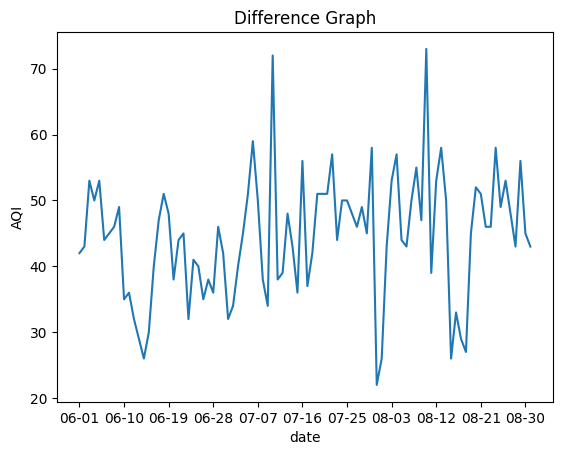

In [1]:
import numpy as np
import pandas as pd
import matplotlib. pyplot as plt
#plt.rcParams['font.family'] = ['sans-serif']
#plt.rcParams['font.sans-serif'] = ['SimHei']
import datetime

#导入数据
urumchi_data = pd.read_csv('./data/week7-wulumuqi.csv', encoding='utf-8', engine='python')
print(urumchi_data)

#获取2021年豆季数据的索引
startIndex=urumchi_data.index[urumchi_data['日期'] == '2021-06-01'].tolist()[0]
endIndex=urumchi_data.index[urumchi_data['日期'] == '2021-08-31'].tolist()[0]

#获取2021年复季的数据,6月到8月的数据作为训练数据
trainUrumchi_data=urumchi_data[startIndex: endIndex+1]
print(trainUrumchi_data)

dateData=trainUrumchi_data ['日期']
AQIData=trainUrumchi_data['AQI指数']

#截取2021-06-01到2021-08-31的月日做差分图的坐标轴
datestart=datetime.datetime.strptime("2021-06-01", '%Y-%m-%d')
dateend=datetime.datetime.strptime("2021-08-31", '%Y-%m-%d')

dateRange=[]
while datestart <= dateend:
    dateRange.append(datestart.strftime('%m-%d'))
    #每隔九天取一个日期
    datestart+=datetime.timedelta(days=9)

#画出差分图
plt.plot(dateData, AQIData)
plt.xlabel("date")
plt.ylabel("AQI")
plt.xticks(dateData[::9], dateRange)
plt.title("Difference Graph")
plt.show()

原始序列的检验结果为: (-6.983882918138686, 8.06132584319893e-10, 0, 91, {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}, 580.9694272582359)
8.06132584319893e-10
-3.50434289821397


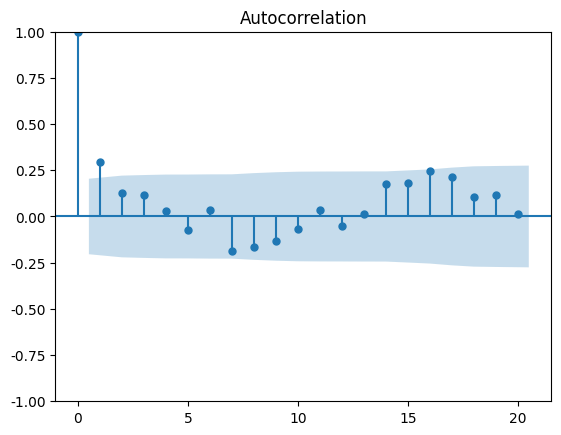

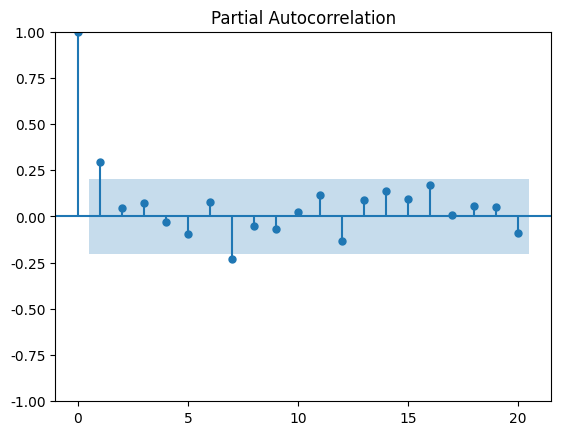

In [2]:
from statsmodels.tsa.stattools import adfuller

print('原始序列的检验结果为:',adfuller(AQIData))
adfResult=adfuller(AQIData)

print(adfResult[1])
print(adfResult[4]['1%'])

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

plot_acf(AQIData) #画出自相关图
plt.show()

plot_pacf(AQIData) #画出偏相关图
plt.show()

In [3]:
from statsmodels.stats.diagnostic import acorr_ljungbox

white_noise=acorr_ljungbox(AQIData, lags=1)


#值为8.42224768e-258,因此为非白噪声
print(u'白噪声检验结果:',white_noise)
#print(white_noise)
print(type(white_noise))
print(white_noise['lb_pvalue'][1])
print(type(white_noise['lb_pvalue'][1]))
stradf=str(white_noise['lb_pvalue'][1])
print(type(stradf))
flotAdf=float(stradf)
print(type(flotAdf))
print(flotAdf)

白噪声检验结果:     lb_stat  lb_pvalue
1  8.110485   0.004401
<class 'pandas.core.frame.DataFrame'>
0.004400995452096759
<class 'numpy.float64'>
<class 'str'>
<class 'float'>
0.004400995452096759


In [4]:
import statsmodels.api as sm

pmax = int(len(AQIData) / 10) #一般阶数不超过 length /10
qmax = int(len(AQIData) / 10)
bic_matrix = []
# 遍历可能的 p 和 q 值
for p in range(pmax + 1):
    temp = []
    for q in range(qmax + 1):
        try:
            # 由于原始数据平稳,因此差分d为0
            value = sm.tsa.arima.ARIMA(AQIData, order=(p, 0, q)).fit().bic
            temp.append(value)
        except Exception as e:
            # 如果出现错误，添加 None 表示模型无法适配
            temp.append(None)
    bic_matrix.append(temp)

# 将列表转换为 DataFrame
bic_matrix = pd.DataFrame(bic_matrix)

# 删除 None 值并转换为 float
bic_matrix = bic_matrix.applymap(lambda x: float(x) if x is not None else np.nan)

# 查找最小 BIC 值及其对应的 p 和 q 值
if not bic_matrix.isnull().all().all():  # 检查是否所有值都是 NaN
    p, q = bic_matrix.stack().idxmin()
    print(u'BIC 最小的p值 和 q值:%s,%s' % (p, q))  # BIC 最小的p值 和 q值
else:
    print("没有找到有效的 BIC 值。请检查输入数据和模型参数。")

/usr/local/python/3.10.4/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/python/3.10.4/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/python/3.10.4/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/python/3.10.4/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/p

BIC 最小的p值 和 q值:1,0


/usr/local/python/3.10.4/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [5]:
model = sm.tsa.arima.ARIMA(AQIData, order=(p,0,q)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  AQI指数   No. Observations:                   92
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -332.691
Date:                Tue, 09 Apr 2024   AIC                            671.382
Time:                        13:39:11   BIC                            678.947
Sample:                             0   HQIC                           674.435
                                 - 92                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.4716      1.336     33.285      0.000      41.853      47.090
ar.L1          0.2893      0.090      3.203      0.001       0.112       0.466
sigma2        80.9302      9.881      8.190      0.0

In [12]:
predictions=model.forecast(7)

print(predictions)
#预测结果为:
pre_result = predictions.iloc[0]
print(u'预测结果为:',pre_result)
#标准误差为:
error = predictions.iloc[1]
print(u'标准误差为:',error)
#置信区河为:
confidence = predictions.iloc[2]
# confidence = predictions[['lower_ci', 'upper_ci']]
print(u'置信区间为:',confidence)

942    44.045822
943    44.348390
944    44.435926
945    44.461252
946    44.468579
947    44.470698
948    44.471312
Name: predicted_mean, dtype: float64
预测结果为: 44.04582189625749
标准误差为: 44.3483900404033
置信区间为: 44.435926438502676
